# Loading data, tokenizing terms

In [1]:
import pandas as pd
import numpy as np
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
df = pd.read_parquet('videogames.parquet')

In [4]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('vidgame-terms.txt'))

In [5]:
subdf = df.sample(50000)
subdf['tokens'] = pd.Series(subdf['reviewText'].progress_apply(tokenizer.tokenize))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [6]:
import tomotopy as tp
import time

# Hyperparameters to adjust

In [26]:
k = 90 #determines shape of whole model
min_df = 20 #any word that doesn't occur in more than x reviews gets ignored, addresses low-frequency words
rm_top = 120 #currently set to top 75 most common words (meant to remove), like stopwords...can adjust to, say, top 100
tw = tp.TermWeight.ONE #everything is weighed the same @ 1, check other strategies
alpha = 0.1 #term distribution
eta = 0.01 #topic distribution, alpha and eta are probably fine. 
tol = 1e-3

In [27]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in subdf['tokens']:
    if doc:
        mdl.add_doc(doc)

#TRAINING LOOP here
last = np.NINF
for i in range(0, 5000, 50):
    mdl.train(50)
    ll = mdl.ll_per_word
    print(f'{i:5d} LL = {ll:7.4f}', flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f'Done!') 

    0 LL = -9.1074
   50 LL = -8.9008
  100 LL = -8.8191
  150 LL = -8.7745
  200 LL = -8.7456
  250 LL = -8.7241
  300 LL = -8.7078
  350 LL = -8.6946
  400 LL = -8.6894
  450 LL = -8.6836
  500 LL = -8.6766
  550 LL = -8.6716
  600 LL = -8.6649
  650 LL = -8.6593
  700 LL = -8.6543
  750 LL = -8.6515
  800 LL = -8.6501
  850 LL = -8.6457
  900 LL = -8.6437
  950 LL = -8.6364
 1000 LL = -8.6371
Done!
CPU times: user 17min 13s, sys: 10.5 s, total: 17min 24s
Wall time: 5min 46s


# Evaluate the Model

In [28]:
for k in range(mdl.k):
    print(f'{k:3d} ', ', '.join(s for s,_ in mdl.get_topic_words(k)))

  0  did, bought, years, before, few, since, came, ago, started, day
  1  animal, animals, park, build, town, crossing, things, food, moon, harvest
  2  controller, battery, charge, usb, works, batteries, controllers, wireless, cable, charging
  3  original, same, first_game, version, improved, lot, 1, different, first_one, previous
  4  tomb_raider, uncharted, ratchet, lara, clank, jak, series, resistance, daxter, platforming
  5  work, product, amazon, bought, did, buy, problem, return, working, replacement
  6  works, product, excellent, came, item, perfect, thanks, condition, thank, fast
  7  zelda, link, sword, nintendo, legend_of_zelda, princess, twilight, ocarina_of_time, dungeons, past
  8  fallout, rpg, quests, character, combat, skyrim, oblivion, quest, dragon_age, hours
  9  short, boring, bit, repetitive, hours, overall, think, lot, game_play, gets
 10  star_wars, lego, force, jedi, battlefront, movies, kotor, powers, side, republic
 11  enemies, souls, boss, dark, god_of_w

In [23]:
', '.join(mdl.removed_top_words)

"the, and, to, a, i, it, you, of, is, game, this, not, in, that, for, are, have, but, with, 's, on, as, can, was, do, like, be, if, my, so, will, your, all, or, there, games, one, just, they, more, get, at, from, play, up, out, very, some, an, has, really, good, when, great, no, me, would, what, about, which, fun, also, well, much, even, time, than, them, am, only, other, by, had, because, new, graphics, does, its, playing, still, 2, then, into, better, first, any, too, story, been, most, over, use, way, played, now, best, after, make, how, could, while, love, many, were, these, go, who, where, 3, want, little, through, characters, back, off, gameplay, their, got, people, pretty, buy, lot, see, different, think"

In [29]:
import pyLDAvis #takes model we've built, converts it (by "rearranging" model) into a form that another tool can use/ingest

topic_term_dists = np.stack([mdl.get_topic_word_dist(k)
                             for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,
                                 doc_topic_dists,
                                 doc_lengths,
                                 vocab,
                                 term_frequency, 
                                 mds='tsne', 
                                 sort_topics=False
                                 )

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


# Visualizing model's qualities

In [30]:
pyLDAvis.display(prepared_data)

In [32]:
for i,d in enumerate(np.argmax(doc_topic_dists, axis=0)):
    print(i, ', '.join(map(first, mdl.get_topic_words(i))))
    print(subdf['reviewText'].iloc[d])
    print()

0 did, bought, years, before, few, since, came, ago, started, day
This little device is a blast.  We got it for Christmas 2008 and the whole family loves it.  The combination of games, exercises and yoga it is very easy to find something for everyone.  I have 4 kids ranging in ages from 10-18 and everyone has used it daily for almost 2 weeks now.
The pad itself seems to be built very durable.  The top is hard white plastic and only a few inches high.  The small size and height are great for sliding under the coach while not in use.  The wireless connection means you don't have the clutter of cords running everywhere.  I can't comment yet on the battery life.
The games/sections of the software are good.  They have good graphics for the games and ok for the yoga/strength sections.  The yoga, strength sections have your choice between a male or female trainer.  The only part of them that bugs me is their lips don't move when they talk, but otherwise they are pleasant and helpful.
I only h

# Wordclouds

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In theory, the paragraphs of text are supposed to be documents that best represent each topic. As of right now, we have candidate terms and find the topics they have the strongest association to, then determine the documents that best represent each of the topics we've used in our model.

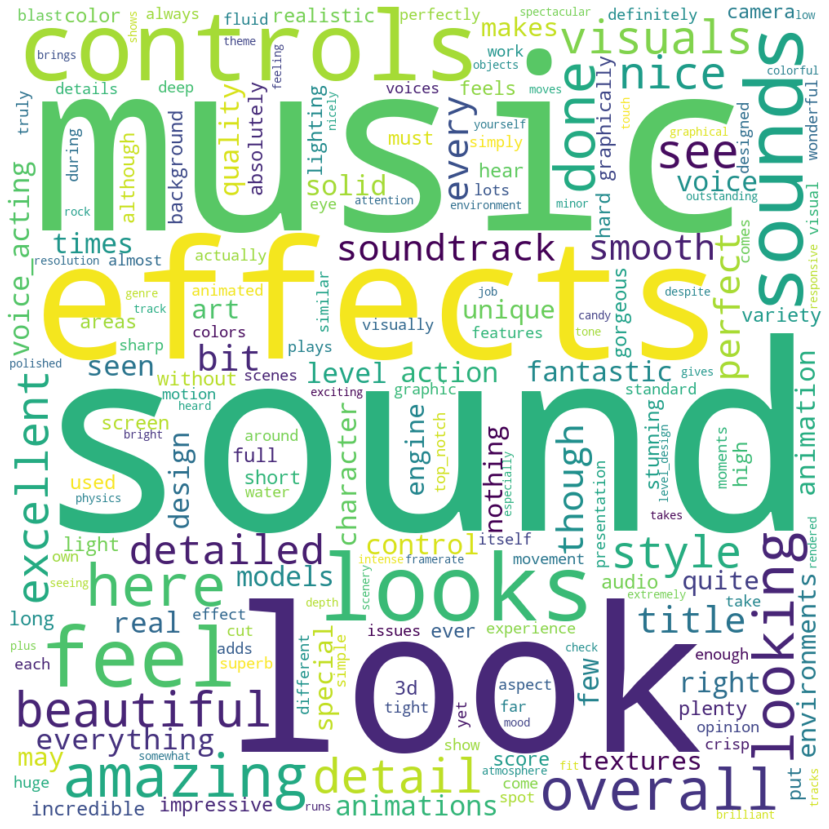

In [42]:
plt.figure(figsize=(15,15))
freqs = dict(mdl.get_topic_words(69, 200))
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

Here, the word clouds are produced by specifiying the topic and amount of terms. In this case, this is "sound" with 200 terms used.

In [43]:
mdl.save('vidgame-topics.bin')